# Global importance analysis of motif spacing
Visualize the results of global importance analysis for the effect of spacing and order of CRX+NRL and CRX+GFI1 motifs.

Required inputs:
* `synthetic_insertion_preds.txt`: the predicted *activity* of each background sequence with a CRX and NRL motif inserted at every possible position. The predicted activity of the the background sequence itself is provided to get the predicted *importance*.
* `GFI1_synthetic_insertion_preds.txt`: same but with GFI1 instead of NRL.

Outputs: `crx{NRL,GFI1}Position.svg` the heatmaps of mean predicted importance of the motifs at each set of positions.

In [1]:
import os
import sys
import itertools
import re

import numpy as np
import pandas as pd
import matplotlib.pyplot as plt
import torch
import selene_sdk
from deeplift.dinuc_shuffle import dinuc_shuffle

from src.mpra_tools import fasta_utils, loaders, modeling, predicted_occupancy, plot_utils

data_dir = "ImportanceAnalysis"
figures_dir = "Figures"
plot_utils.set_manuscript_params()

import plotly.graph_objects as go

/ref/bclab/software/ryan/.conda/envs/active-learning/lib/python3.9/site-packages/tqdm/auto.py:22: TqdmWarning: IProgress not found. Please update jupyter and ipywidgets. See https://ipywidgets.readthedocs.io/en/stable/user_install.html
  from .autonotebook import tqdm as notebook_tqdm


Load in datasets.

In [2]:
datasets = [
    ("nrl", "CrxNrl", "synthetic_insertion_preds.txt"),
    ("GFI1", "Crx_Anytf", "GFI1_synthetic_insertion_preds.txt")
]
matrices = {}

for tf, subdir, f in datasets:
    importance_df = loaders.load_data(os.path.join(data_dir, subdir, f))
    shuffle_seq = importance_df["shuffle_seq"]
    gc_content = importance_df["gc_content"]
    importance_df = importance_df.drop(columns=["shuffle_seq", "gc_content"])
    #subtract out the background
    background = importance_df["background"]
    importance_df = importance_df.subtract(background, axis="index")
    means = importance_df.apply(np.mean, axis = "index")
    means = pd.DataFrame(means)
    means = means.drop(index="background")
    means["label"] = means.index
    means["crx"] = means["label"].str.split("crx").str[0].astype(int)
    means[tf] = means["label"].str.split("crx").str[1]
    means[tf] = means[tf].str.split(tf).str[0].astype(int)
    means = means.rename(columns= {0: "expression"})
    loaders.write_data(means, os.path.join(data_dir, subdir, "means.txt"), index=False)
    
    matrices[tf] = means

Visualize the data aggregated along one of the two axes to see the trend of effect for the position of one TF.

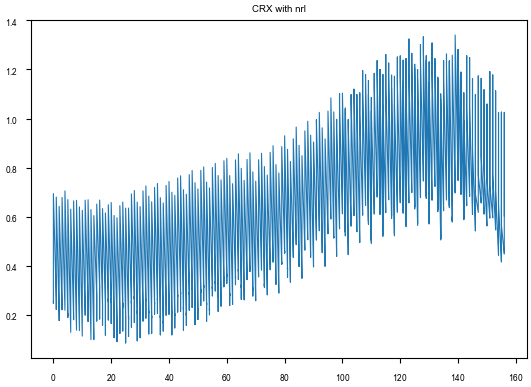

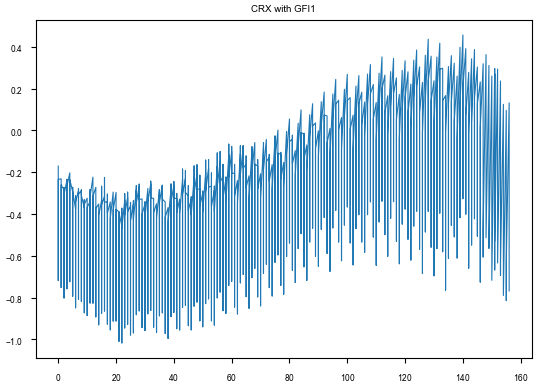

In [3]:
# Position of CRX
for tf, means in matrices.items():
    fig, ax = plt.subplots()
    fig = plt.plot(means["crx"], means["expression"])
    ax.set_title(f"CRX with {tf}")

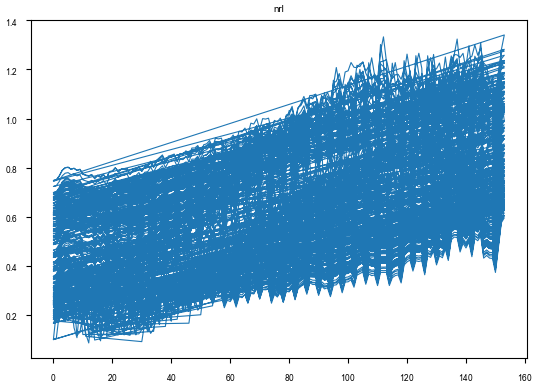

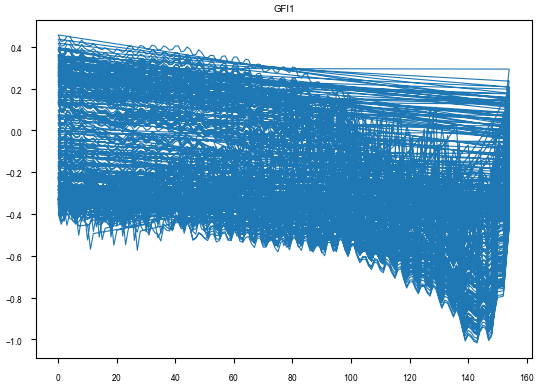

In [4]:
# Position of other
for tf, means in matrices.items():
    fig, ax = plt.subplots()
    fig = plt.plot(means[tf], means["expression"])
    ax.set_title(tf)

Interactive heatmap for in-depth analysis.

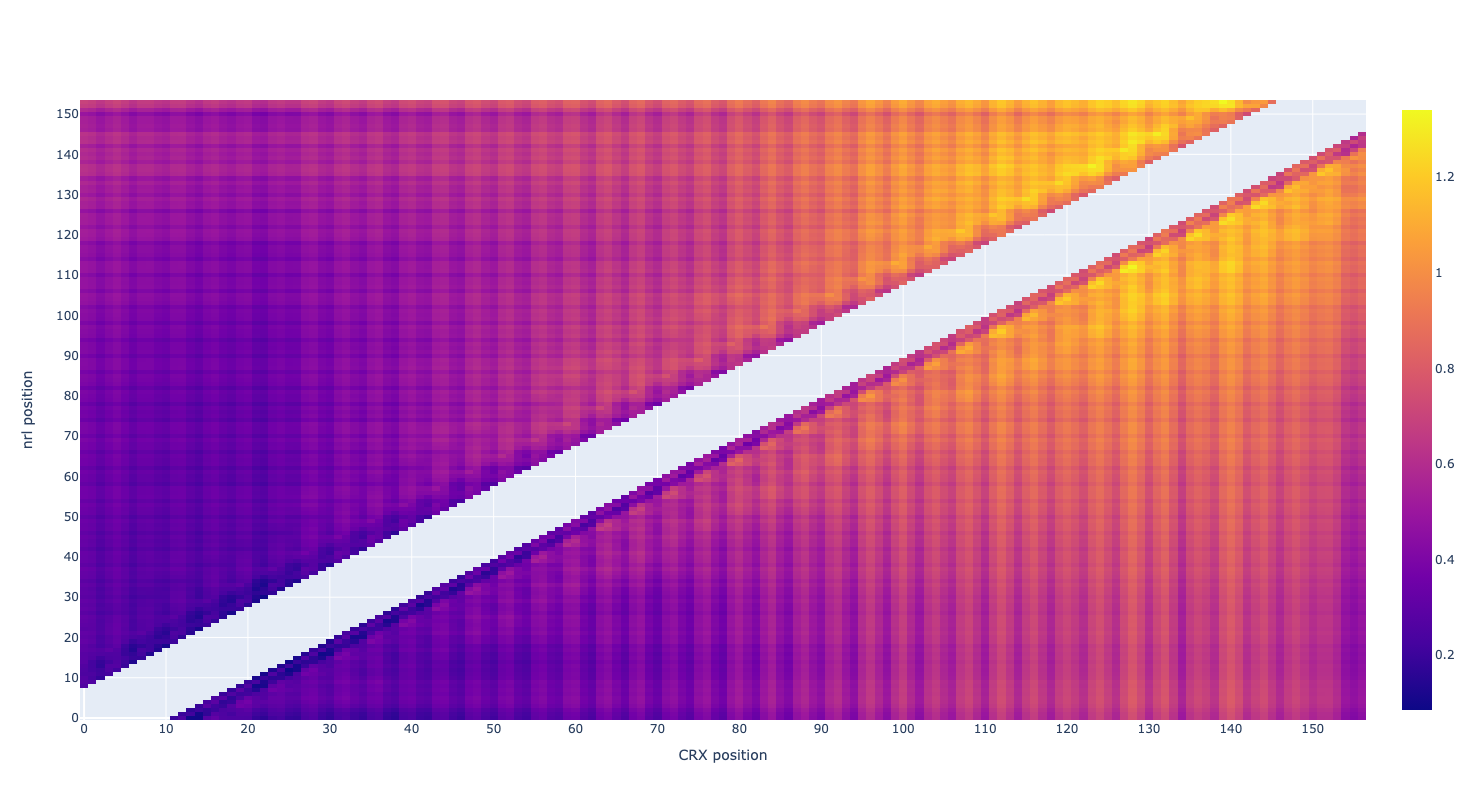

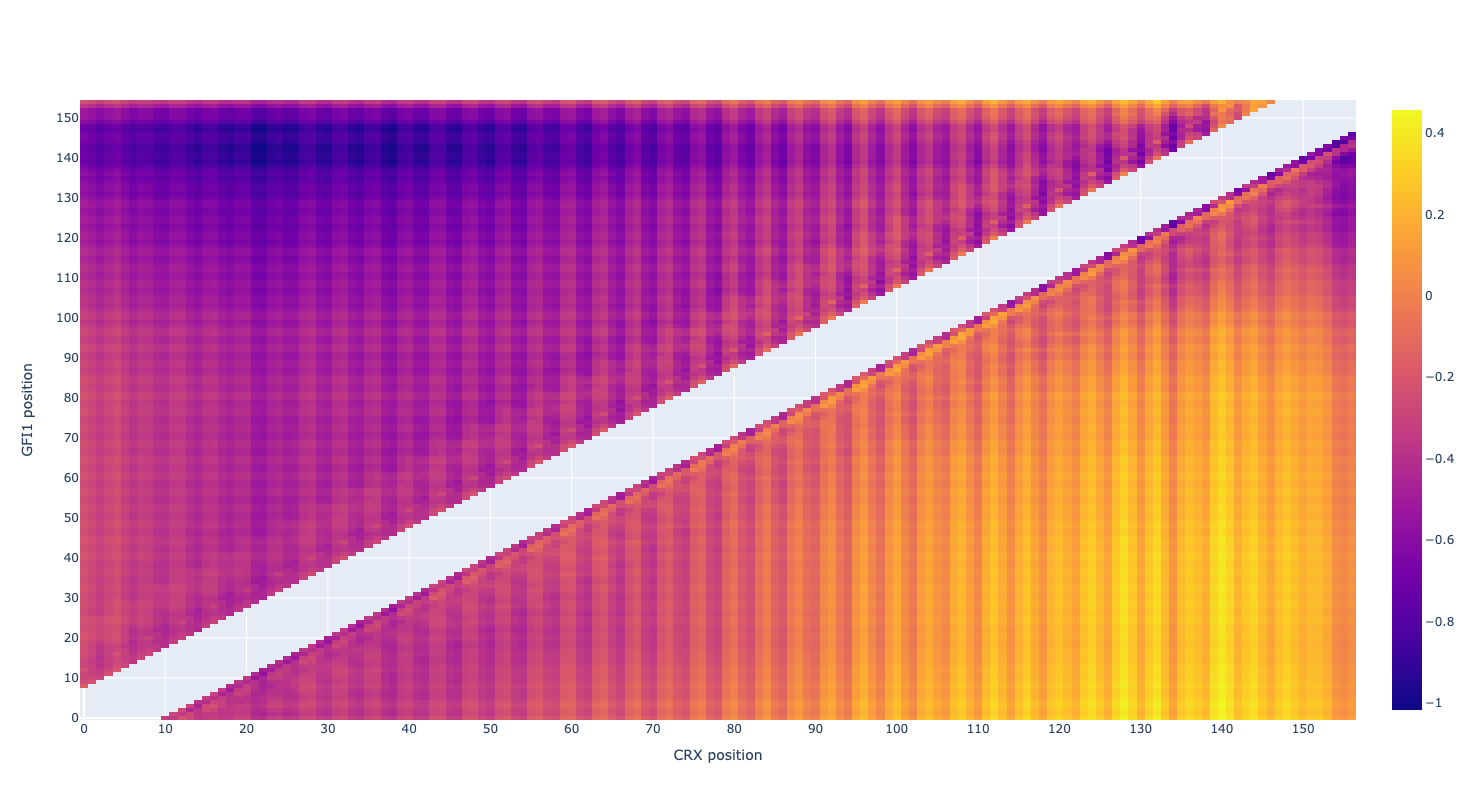

In [5]:
for tf, means in matrices.items():
    sorted_other_positions =  np.sort(means[tf].unique().astype(int))
    sorted_crx_positions =  np.sort(means.crx.unique().astype(int))
    fig = go.Figure(data = go.Heatmap(
                       z = means["expression"],
                       x = means["crx"],
                       y = means[tf],
                       hoverongaps = False),
                    layout = go.Layout(
                        xaxis = {'title':'CRX position', 'categoryorder':'array', 'categoryarray': sorted_crx_positions},
                        yaxis = {'title': f'{tf} position', 'categoryorder':'array', 'categoryarray': sorted_other_positions},
                        height = 800,
                        hovermode='closest'))
    # fig.update_layout(font_size=24)
    fig.update_layout(
        yaxis = dict(
            tickmode = 'linear',
            tick0 = 10,
            dtick = 10
        )
    )
    fig.update_layout(
        xaxis = dict(
            tickmode = 'linear',
            tick0 = 10,
            dtick = 10
        )
    )
    fig.show()

Heatmap for the manuscript.

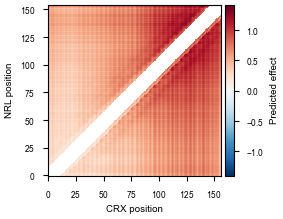

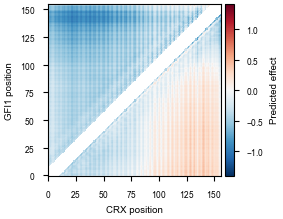

In [6]:
import matplotlib.colors as colors
from matplotlib import cm

cmap = cm.RdBu_r

ticks = np.arange(0, 151, 25)
for tf, means in matrices.items():
    pivoted = means.pivot(
        index=tf,
        columns="crx",
        values="expression"
    )

    fig, ax = plot_utils.make_heatmap(
        pivoted,
        cbar_label="Predicted effect",
        figax=plt.subplots(figsize=plot_utils.get_figsize(0.35, 1)),
        cmap=cmap,
        norm=colors.CenteredNorm(halfrange=1.4079928776071955),
    )
    ax.set_xticks(ticks)
    ax.set_yticks(ticks)
    ax.invert_yaxis()
    ax.set_xlabel("CRX position")
    ax.set_ylabel(f"{tf.upper()} position")
    
    # ylim of the cmap
    # print(fig.axes[1].get_ylim())
    
    plot_utils.save_fig(fig, os.path.join(figures_dir, f"crx{tf.capitalize()}Position"))